In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(0)

In [10]:
def plot_2d_data(df):
    prev_year_price = df.prev_year_price
    number_of_users = df.number_of_users
    tenant_age_in_days = df.tenant_age_in_days
    number_of_bug_reports = df.number_of_bug_reports
    current_year_price = df.current_year_price

    # create 3 subplots for each feature with future_price
    fig, ax = plt.subplots(1, 4, figsize=(22, 4))
    # space between subplots
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle('Feature vs Future Price', fontsize=16)
    for i, feature in enumerate([prev_year_price, number_of_users, tenant_age_in_days, number_of_bug_reports]):
        ax[i].plot(feature, current_year_price, 'o')
        ax[i].set_xlabel(feature.name)
        ax[i].set_ylabel('Future Price')

    plt.show()


def plot_predictions(X_test, y_test, y_pred):
    fig, ax = plt.subplots(1, 3, figsize=(22, 4))
    fig.suptitle('Feature vs Predicted Future Price', fontsize=16)

    for i, feature in enumerate(['prev_year_price', 'number_of_users', 'tenant_age_in_days']):
        ax[i].plot(X_test[feature], y_pred, 'o', label='Predicted')
        ax[i].plot(X_test[feature], y_test, 'o', label='True')
        ax[i].set_xlabel(feature)
        ax[i].legend()

    plt.show()


def plot_line_for_each_feature(regressor, X_test, y_test, y_pred):
    # plot sgd regressor line for each feature using the coefficients and bias
    bias = regressor.intercept_

    fig, ax = plt.subplots(1, len(X_test.columns), figsize=(22, 4))
    fig.suptitle('Each feature vs Predicted Future Price', fontsize=16)

    for i, feature in enumerate(X_test.columns):
        ax[i].plot(X_test[feature], y_pred, 'o', label='Predicted')
        ax[i].plot(X_test[feature], y_test, 'o', label='True')
        ax[i].plot(X_test[feature], regressor.coef_[i] * X_test[feature] + bias, label='SGDRegressor')
        ax[i].set_xlabel(feature)
        ax[i].legend()


# Data Exploration

Data exploration is the first step in the data analysis process. It is the process of getting familiar with the data, and it is the foundation for the rest of the analysis. 

1. Use df.head() to display the first few rows of the dataset.
2. Use df.describe() to get the summary statistics of the dataset.
3. use plot_2d_data(df) to plot the 2D data.

In [13]:
df = pd.read_csv('customer_sales.csv')

# use the method df.describe() to get the statistics of the dataset
# YOUR CODE HERE
display(df.head())
df.describe()

,prev_year_price,tenant_age_in_days,current_year_price,number_of_users,number_of_bug_reports
0,330211.0,12935.0,216644.073849,544.0,51.0
1,165065.0,1037.0,162699.184691,917.0,16.0
2,271188.0,1996.0,310421.299457,1154.0,0.0
3,166354.0,8077.0,114711.211054,940.0,53.0
4,32066.0,495.0,18039.901422,185.0,57.0


,prev_year_price,tenant_age_in_days,current_year_price,number_of_users,number_of_bug_reports
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,183647.643000,6408.067000,128499.155035,665.674000,50.445000
std,97196.351009,3800.857829,89522.975405,448.926975,29.267688
min,10732.000000,37.000000,3257.040844,13.000000,0.000000
25%,101494.000000,3108.000000,54202.149145,299.000000,25.000000
50%,188401.000000,6263.500000,111940.099639,604.000000,52.000000
75%,265817.750000,9684.500000,189841.708152,948.000000,76.000000
max,349820.000000,13139.000000,401099.613205,2393.000000,99.000000


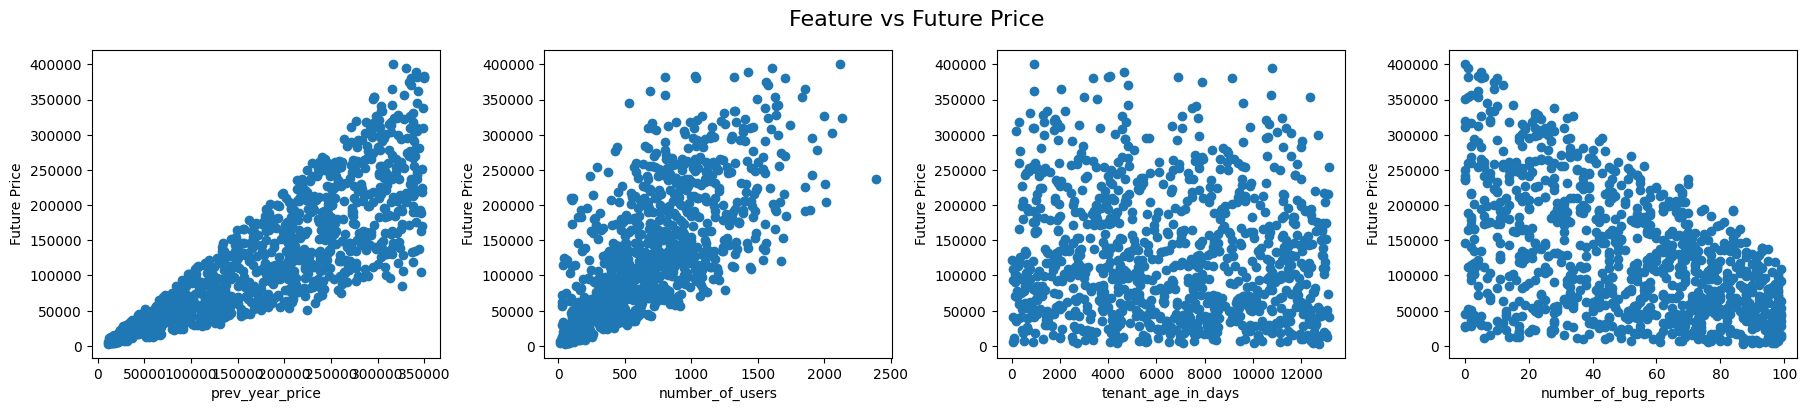

In [14]:
# Enable the plot_2d_data function to visualize the data
plot_2d_data(df)


# Feature Engineering

Feature engineering is the process of using domain knowledge to create new features from the existing features. It is the process of selecting the most important features and creating new features from the existing features.
In our case, we will use all the features as they are. We will not create new features from the existing features.

1. Normalize the data using the following formula: $$\frac{x - min(x)}{max(x) - min(x)}$$ </br>
Use the df.min() and df.max() functions and directly apply it to all values in the dataframe.
2. Once applied we copy the current_year_price (the target variable) as we want to keep the original data for predictions.

In [16]:
# normalize the data
# df_norm = #TODO: complete data normalization

df_norm = (df - df.min()) / (df.max() - df.min())

# Uncomment the following line to copy the original current_year_price to the normalized dataframe
# we want to predict "y" (the current_year_price) based on the other features, so we don't normalize it
df_norm['current_year_price'] = df['current_year_price']

In [18]:
df_norm.head()

,prev_year_price,tenant_age_in_days,current_year_price,number_of_users,number_of_bug_reports
0,0.942171,0.984430,216644.073849,0.223109,0.515152
1,0.455141,0.076324,162699.184691,0.379832,0.161616
2,0.768107,0.149519,310421.299457,0.479412,0.000000
3,0.458943,0.613647,114711.211054,0.389496,0.535354
4,0.062916,0.034956,18039.901422,0.072269,0.575758


In [17]:
# describe the normalized dataframe - can you tell the difference?
df_norm.describe()

,prev_year_price,tenant_age_in_days,current_year_price,number_of_users,number_of_bug_reports
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.509943,0.486267,128499.155035,0.274233,0.509545
std,0.286640,0.290098,89522.975405,0.188625,0.295633
min,0.000000,0.000000,3257.040844,0.000000,0.000000
25%,0.267665,0.234392,54202.149145,0.120168,0.252525
50%,0.523961,0.475233,111940.099639,0.248319,0.525253
75%,0.752270,0.736338,189841.708152,0.392857,0.767677
max,1.000000,1.000000,401099.613205,1.000000,1.000000


# Dataset preparation

1. We split the data intro features and target variable (X and y)
2. We split the data into training and testing sets (80% training, 20% testing)

In [21]:
# select the 4 features for X: 'prev_year_price', 'number_of_users', 'tenant_age_in_days', 'number_of_bug_reports'
# You can select them by using df_norm[['feature1', 'feature2', 'feature3', 'feature4']]....
# X = TODO: complete the selection of the features
X = df_norm[['prev_year_price', 'number_of_users', 'tenant_age_in_days', 'number_of_bug_reports']]

# select the target for y: 'current_year_price'
# y = TODO: complete the selection of the target
y = df_norm[['current_year_price']]


In [22]:
# we use the train_test_split function to split the data into training and testing sets
# Uncomment the following line to split the data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Model training

In [23]:
# We define the regressor SGD Regressor model which is a linear regression model
loss = 'squared_error'  # MSE loss
alpha = 0.0001  # the learning rate
max_iter = 1000  # number of iterations
tol = 1e-3  # stopping criterion - what is the minimum change in the cost function to stop the iterations

# uncomment to define the regressor model
regressor = SGDRegressor(loss=loss, alpha=alpha, max_iter=max_iter, tol=tol)

In [24]:
# Use the fit method to train the model on the X_train and y_train
# The model will learn the coefficients and bias that minimize the loss function

# TODO: fit the model
regressor.fit(X_train, y_train)

/Users/roy.benyosef/dev/daniel-ml-session/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor()

In [26]:
# Make predictions using the predict method on the X_test
# put the predictions in the variable y_pred

# y_pred = TODO: make predictions
y_pred = regressor.predict(X_test)


# Results

In [27]:
# print the coefficients
print('Coefficients: \n', regressor.coef_)

# print the bias (free parameter in the model)
print('Bias: \n', regressor.intercept_)

# print the mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

Coefficients: 
 [ 204548.38182011   98268.32918926    -325.8038527  -146078.69234671]
Bias: 
 [71954.27175391]
Mean squared error: 585642188.64


## Visualize the line equation for each feature

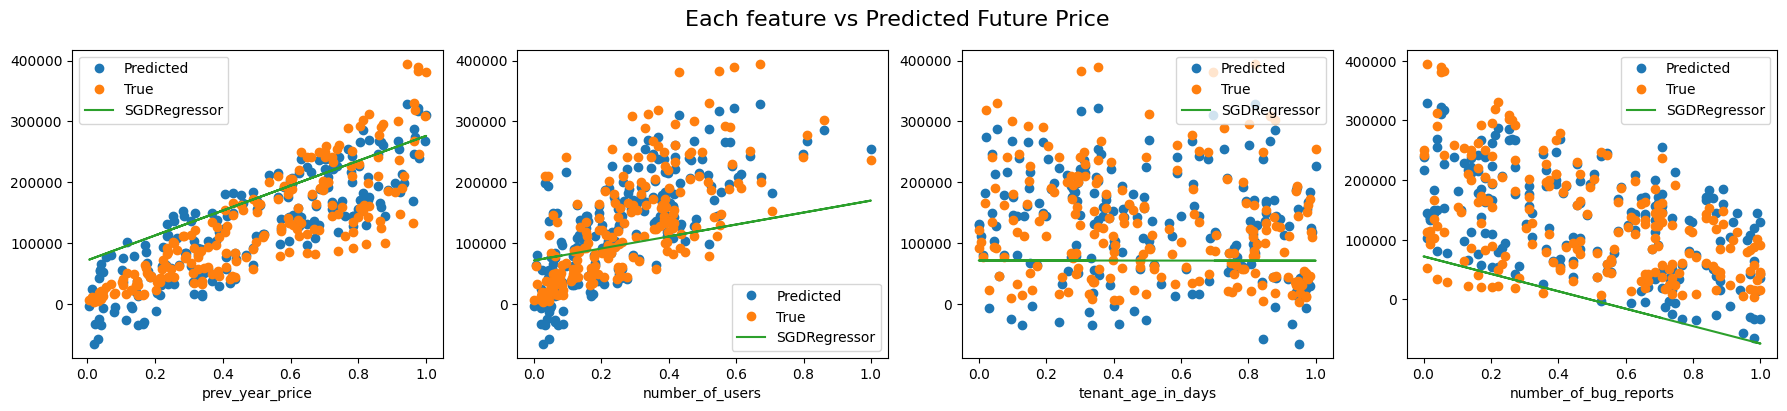

In [28]:
# uncomment to plot the predictions
plot_line_for_each_feature(regressor, X_test, y_test, y_pred)


# Further Learning

**Not a must but enhance your understanding.**

try different hyper parameters and see how they impact the predictions. </br>
In particular, try different alpha and max_iter values and see how they impact the predictions.

In [23]:
loss = 'squared_error'  # MSE loss
alpha = 0.0001  # the learning rate  [0.0001, 0.001, 0.01, 0.1, 1, 10]
max_iter = 1000  # number of iterations  [10, 100, 1000, 10000]
tol = 1e-3  # stopping criterion  [1, 0.1, 0.01, 0.001, 0.0001]

In [24]:
# uncomment to define the regressor model
# regressor = SGDRegressor(loss=loss, alpha=alpha, max_iter=max_iter, tol=tol)

# Fit the model on the entire dataset

# Make predictions using the predict method on the X_test

# uncomment to plot the predictions
# plot_line_for_each_feature(regressor, X_test, y_test, y_pred)
